In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sb
import scipy.stats       as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## 1. 데이터의 열을 test_data의 열을 기준으로 정렬한다

In [2]:
test_data=pd.read_csv('./1번문제data/test data.csv',sep=',' )
train_data=pd.read_csv('./1번문제data/train, validation data.csv',sep=',')
train_data= train_data[test_data.columns]
print(test_data.shape,train_data.shape)

(4320578, 27) (4244716, 27)


In [3]:
test_data['dateTime']=test_data['dateTime'].astype('datetime64')
train_data['dateTime']=train_data['dateTime'].astype('datetime64')

## 2. 결측값있는 행 처리하기

In [4]:
print(test_data.isnull().sum().sum(),train_data.isnull().sum().sum())

0 0


결측값이 있는 행이 없다.

## 3. dateTime(시계열)이 중복된 행 삭제하기

In [5]:
test_data=test_data.drop_duplicates(['dateTime','state'],keep='first')
train_data=train_data.drop_duplicates(['dateTime','state'],keep='first')
print(test_data.shape,train_data.shape)

(4320577, 27) (4243631, 27)


## 4. dateTime 순으로 정렬하기

In [6]:
test_data=test_data.sort_values('dateTime',ascending=True)
train_data=train_data.sort_values('dateTime',ascending=True)

## 5. 센서 데이터의 특징을 고려하여 이상치 제거하기

설명: 센서의 종류를 크게 온도, 압력, 속도로 나타낼 수 있다. 또한 fuel mode selected는 0,1,2,3으로만 이루어저야하고 온도는 절대온도 -273.15보다 커야하고, 압력은 엔진 연소 cycle에 들어가는 센서들은 주로 절대압이므로 0보다 크거나 같아야하고 나머지 주변 구동기기(DVT같은)에 붙은 센서들은 보통 gauage센서를 써서 대기압과의 차이값이므로 음수여도 0으로 바꾸면 된다.

그리고 IMEP, speed, Pmax average, Engine Speed, Engine Load percent는 0보다 크거나 같아야한다.

1. 온도 

In [7]:
# 각 종류별로 센서 데이터 고려하기
# 1. 온도 data
Temperature=['Air temp, TC inlet (TE29)','Charge Air temp, Engine Inlet (TE21X)','Exh. Gas temp average','Exh. Gas temp, TC Inlet','Exh. Gas temp, TC Outlet','FO Temperature Engine Inlet','Gas temp (TE81)','HT CW temp, Engine Inlet (TE75)','HT CW temp, Engine Outlet (TE76)','LT CW temp, Air Cooler Inlet (TE71)','LT CW temp, Air Cooler Outlet (TE72)','Main bearing temp average']
Standard=-273.15
for i in Temperature:
    #test
    where_error=np.array(np.where(test_data[i].values<Standard))[0]
    if len(where_error)>0:
        test_data=test_data.drop(index=where_error)
        print(i,len(where_error),test_data.shape)
    #train
    where_error=np.array(np.where(train_data[i].values<Standard))[0]
    if len(where_error)>0:
        train_data=train_data.drop(index=where_error)
        print(i,len(where_error),train_data.shape)      

2. 압력

In [8]:
#incycle
Incycle=['Charge Air press, Engine Inlet (PT21X)','FO Pressure Engine Inlet','Gas press, Engine Inlet (PT87)']
Standard=0
for i in Incycle:
    #test
    where_error=np.array(np.where(test_data[i].values<Standard))[0]
    if len(where_error)>0:
        test_data=test_data.drop(index=where_error)
        print(i,len(where_error),test_data.shape)
    #train
    where_error=np.array(np.where(train_data[i].values<Standard))[0]
    if len(where_error)>0:
        train_data=train_data.drop(index=where_error)
        print(i,len(where_error),train_data.shape)  

Gas press, Engine Inlet (PT87) 66 (4320511, 27)


3. 다른 것들

In [9]:
Else=['Fuel mode selected','Waste Gate Valve position command (CV26)','Base duration gas admission','state','dateTime']
Select=['Engine Load percent','Engine Speed 1 (SE11)','IMEP average','Pmax average']
Standard=0
for i in Select:
    #test
    where_error=np.array(np.where(test_data[i].values<Standard))[0]
    if len(where_error)>0:
        test_data=test_data.drop(index=where_error)
        print(i,len(where_error),test_data.shape)
    #train
    where_error=np.array(np.where(train_data[i].values<Standard))[0]
    if len(where_error)>0:
        train_data=train_data.drop(index=where_error)
        print(i,len(where_error),train_data.shape)  

Engine Load percent 4 (4320507, 27)
IMEP average 277 (4320230, 27)


4. Fuel mode selected 분석 후 dateTime으로 다시 정렬하기

In [10]:
print(list(test_data['Fuel mode selected'].unique()),list(train_data['Fuel mode selected'].unique()))
test_data=test_data.sort_values('dateTime',ascending=True)
test_data.index=np.arange(len(test_data))
train_data=train_data.sort_values('dateTime',ascending=True)
train_data.index=np.arange(len(train_data))

[2, 3] [3.0, 2.0]


## 6. 선형 보간하기

1. 나누기

In [11]:
OneSecond=test_data.iloc[1,25]-test_data.iloc[0,25]
numofdata=[]

In [12]:
#test_data
temp=test_data
where_something1=np.array(np.where(temp['state'].iloc[1:].values==temp['state'].iloc[:-1].values))[0]
where_something2=np.array(np.where(temp['Fuel mode selected'].iloc[1:].values==temp['Fuel mode selected'].iloc[:-1].values))[0]
where_temp=list(set(where_something1).intersection(set(where_something2)))
where_something3=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
where_something=list(set(where_something3).intersection(set(where_temp)))
where_something=sorted(where_something)
for i in range(len(where_something)+1):
    if i==0:
        test_data_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="test_data_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="test_data_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
numofdata.append(len(where_something)+1) 

In [13]:
#train_data
temp=train_data
where_something1=np.array(np.where(temp['state'].iloc[1:].values==temp['state'].iloc[:-1].values))[0]
where_something2=np.array(np.where(temp['Fuel mode selected'].iloc[1:].values==temp['Fuel mode selected'].iloc[:-1].values))[0]
where_temp=list(set(where_something1).intersection(set(where_something2)))
where_something3=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
where_something=list(set(where_something3).intersection(set(where_temp)))
where_something=sorted(where_something)
for i in range(len(where_something)+1):
    if i==0:
        train_data_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="train_data_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="train_data_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
numofdata.append(len(where_something)+1) 
where_something=0

In [14]:
numofdata

[697, 1571]

2. 선형 보간

In [15]:
NumOfData=[]
n=5
Standard=n*OneSecond
Columns=test_data.columns

In [16]:
for i in range(numofdata[0]-1):
    s1="First=test_data_%d" %(i+1)
    s2="Second=test_data_%d"%(i+2)
    exec(s1)
    exec(s2)
    diff=Second['dateTime'].iloc[0]-First['dateTime'].iloc[-1]
    if diff<=Standard:
         #m-1행짜리 빈 행 만들기
        NewData=pd.DataFrame(columns=Columns)
        for j in range(1,int(diff/OneSecond)):
            NewData=NewData.append({},ignore_index=True)
            NewData['dateTime'].iloc[j-1]=First['dateTime'].iloc[-1]+j*OneSecond
            NewData['Fuel mode selected'].iloc[j-1]=First['Fuel mode selected'].iloc[-1]
            NewData['state'].iloc[j-1]=First['state'].iloc[-1]
        # 데이터 합치기- First,NewData, Second순
        TempData=pd.concat([First,NewData],axis=0)
        TempData=pd.concat([TempData,Second],axis=0)
        TempData[Columns[:-2]]=TempData[Columns[:-2]].astype('float')
        TempData.index=np.arange(len(TempData))
        TempData=TempData.interpolate(method='linear')
        #First데이터는 빈 데이터로 Second데이터이름으로 변경하기 
        s3="test_data_%d=pd.DataFrame()" %(i+1)
        s4="test_data_%d=TempData" %(i+2) # Second데이터= TempData
        exec(s3)
        exec(s4)
    if i%10==0:
        print(i)

#개수 세기
Num=0
for i in range(numofdata[0]):
    s5="temp=test_data_%d" %(i+1)
    exec(s5)
    if temp.shape!=(0,0):
        Num+=1
        s6="test_data_%d=temp" %(Num)
        exec(s6)
NumOfData.append(Num)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690


In [17]:
for i in range(numofdata[1]-1):
    s1="First=train_data_%d" %(i+1)
    s2="Second=train_data_%d"%(i+2)
    exec(s1)
    exec(s2)
    diff=Second['dateTime'].iloc[0]-First['dateTime'].iloc[-1]
    if diff<=Standard:
         #m-1행짜리 빈 행 만들기
        NewData=pd.DataFrame(columns=Columns)
        for j in range(1,int(diff/OneSecond)):
            NewData=NewData.append({},ignore_index=True)
            NewData['dateTime'].iloc[j-1]=First['dateTime'].iloc[-1]+j*OneSecond
            NewData['Fuel mode selected'].iloc[j-1]=First['Fuel mode selected'].iloc[-1]
            NewData['state'].iloc[j-1]=First['state'].iloc[-1]
        # 데이터 합치기- First,NewData, Second순
        TempData=pd.concat([First,NewData],axis=0)
        TempData=pd.concat([TempData,Second],axis=0)
        TempData[Columns[:-2]]=TempData[Columns[:-2]].astype('float')
        TempData.index=np.arange(len(TempData))
        TempData=TempData.interpolate(method='linear')
        #First데이터는 빈 데이터로 Second데이터이름으로 변경하기 
        s3="train_data_%d=pd.DataFrame()" %(i+1)
        s4="train_data_%d=TempData" %(i+2) # Second데이터= TempData
        exec(s3)
        exec(s4)
    if i%10==0:
        print(i)

#개수 세기
Num=0
for i in range(numofdata[1]):
    s5="temp=train_data_%d" %(i+1)
    exec(s5)
    if temp.shape!=(0,0):
        Num+=1
        s6="train_data_%d=temp" %(Num)
        exec(s6)
NumOfData.append(Num)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560


In [18]:
NumOfData

[40, 881]

3. 데이터 합치기

In [19]:
Data=pd.DataFrame()
#test data
for i in range(NumOfData[0]):
    s1="temp=test_data_%d" %(i+1)
    exec(s1)
    Data=pd.concat([Data,temp])
test_data=Data

Data=pd.DataFrame()
#train data
for i in range(NumOfData[1]):
    s1="temp=train_data_%d" %(i+1)
    exec(s1)
    Data=pd.concat([Data,temp])
train_data=Data

In [20]:
test_data[Columns[:-2]]=test_data[Columns[:-2]].astype('float')
train_data[Columns[:-2]]=train_data[Columns[:-2]].astype('float')
test_data['dateTime']=test_data['dateTime'].astype('datetime64')
train_data['dateTime']=train_data['dateTime'].astype('datetime64')
test_data.index=np.arange(len(test_data))
train_data.index=np.arange(len(train_data))

## 7. mode2, mode3, 정상 고장으로 나누기

In [21]:
# test data
test_mode2=test_data[test_data['Fuel mode selected']==2].sort_values('dateTime',ascending=True)
test_mode3=test_data[test_data['Fuel mode selected']==3].sort_values('dateTime',ascending=True)
print(np.all(test_mode2['Fuel mode selected']==2))
print(np.all(test_mode3['Fuel mode selected']==3))
#train data
train_mode2=train_data[train_data['Fuel mode selected']==2].sort_values('dateTime',ascending=True)
train_mode3=train_data[train_data['Fuel mode selected']==3].sort_values('dateTime',ascending=True)
print(np.all(train_mode2['Fuel mode selected']==2))
print(np.all(train_mode3['Fuel mode selected']==3))

True
True
True
True


In [22]:
test_normal_mode2=test_mode2[test_mode2['state']=='normal'].sort_values('dateTime',ascending=True)
test_abnormal_mode2=test_mode2[test_mode2['state']=='abnormal'].sort_values('dateTime',ascending=True)
test_normal_mode3=test_mode3[test_mode3['state']=='normal'].sort_values('dateTime',ascending=True)
test_abnormal_mode3=test_mode3[test_mode3['state']=='abnormal'].sort_values('dateTime',ascending=True)

train_normal_mode2=train_mode2[train_mode2['state']=='normal'].sort_values('dateTime',ascending=True)
train_abnormal_mode2=train_mode2[train_mode2['state']=='abnormal'].sort_values('dateTime',ascending=True)
train_normal_mode3=train_mode3[train_mode3['state']=='normal'].sort_values('dateTime',ascending=True)
train_abnormal_mode3=train_mode3[train_mode3['state']=='abnormal'].sort_values('dateTime',ascending=True)

print(np.all(test_normal_mode2['state']=='normal'))
print(np.all(test_normal_mode3['state']=='normal'))
print(np.all(test_abnormal_mode2['state']=='abnormal'))
print(np.all(test_abnormal_mode3['state']=='abnormal'))
print(np.all(train_normal_mode2['state']=='normal'))
print(np.all(train_normal_mode3['state']=='normal'))
print(np.all(train_abnormal_mode2['state']=='abnormal'))
print(np.all(train_abnormal_mode3['state']=='abnormal'))

True
True
True
True
True
True
True
True


## 7.  새 변수 만들기

In [23]:
Columns=list(test_data.columns[:12])+list(test_data.columns[13:-2])+['(Load-b)/(IMEP+1)','(Pmax average-b)/(IMEP+1)','Load/(IMEP+1 x Engine speed+1)']+list(test_data.columns[-2:])+[test_data.columns[12]]

1. (Load-b)/(IMEP+1)

-4.217958269249104 0.8132993772700815


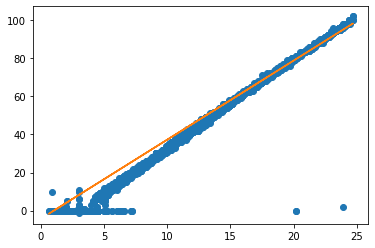

In [24]:
#test_data_mode2
Line= LinearRegression()
temp=test_normal_mode2
x=pd.Series(temp['IMEP average'].values+1)
y=temp['Engine Load percent']
Line.fit(x.values.reshape(-1,1), y)
print(Line.intercept_,mean_squared_error(y,Line.predict(x.values.reshape(-1,1)))**0.5)
plt.plot(x, y, 'o')
plt.plot(x,Line.predict(x.values.reshape(-1,1)))
plt.show()


#test_normal_mode2
temp=test_normal_mode2
test_normal_mode2['(Load-b)/(IMEP+1)']=(temp['Engine Load percent'].values-Line.intercept_)/(temp['IMEP average'].values+1)


#test_abnormal_mode2
temp=test_abnormal_mode2
test_abnormal_mode2['(Load-b)/(IMEP+1)']=(temp['Engine Load percent'].values-Line.intercept_)/(temp['IMEP average'].values+1)


-10.545659223570553 0.4732925095432746


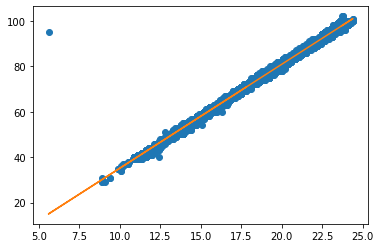

In [25]:
#test_data_mode3
Line= LinearRegression()
temp=test_normal_mode3
x=pd.Series(temp['IMEP average'].values+1)
y=temp['Engine Load percent']
Line.fit(x.values.reshape(-1,1), y)
print(Line.intercept_,mean_squared_error(y,Line.predict(x.values.reshape(-1,1)))**0.5)
plt.plot(x, y, 'o')
plt.plot(x,Line.predict(x.values.reshape(-1,1)))
plt.show()


#test_normal_mode3
temp=test_normal_mode3
test_normal_mode3['(Load-b)/(IMEP+1)']=(temp['Engine Load percent'].values-Line.intercept_)/(temp['IMEP average'].values+1)


#test_abnormal_mode3
temp=test_abnormal_mode3
test_abnormal_mode3['(Load-b)/(IMEP+1)']=(temp['Engine Load percent'].values-Line.intercept_)/(temp['IMEP average'].values+1)

train

-6.7597289710597295 0.17382697265991742


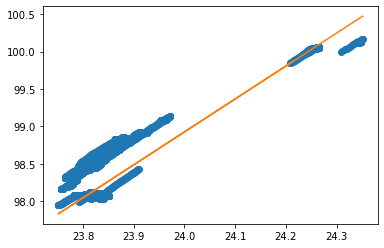

In [26]:
#train_data_mode2
Line= LinearRegression()
temp=train_normal_mode2
x=pd.Series(temp['IMEP average'].values+1)
y=temp['Engine Load percent']
Line.fit(x.values.reshape(-1,1), y)
print(Line.intercept_,mean_squared_error(y,Line.predict(x.values.reshape(-1,1)))**0.5)
plt.plot(x, y, 'o')
plt.plot(x,Line.predict(x.values.reshape(-1,1)))
plt.show()


#train_normal_mode2
temp=train_normal_mode2
train_normal_mode2['(Load-b)/(IMEP+1)']=(temp['Engine Load percent'].values-Line.intercept_)/(temp['IMEP average'].values+1)


#train_abnormal_mode2
temp=train_abnormal_mode2
train_abnormal_mode2['(Load-b)/(IMEP+1)']=(temp['Engine Load percent'].values-Line.intercept_)/(temp['IMEP average'].values+1)

-10.325126960909728 0.17648624654768197


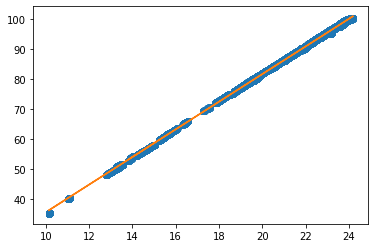

In [27]:
#train_data_mode3
Line= LinearRegression()
temp=train_normal_mode3
x=pd.Series(temp['IMEP average'].values+1)
y=temp['Engine Load percent']
Line.fit(x.values.reshape(-1,1), y)
print(Line.intercept_,mean_squared_error(y,Line.predict(x.values.reshape(-1,1)))**0.5)
plt.plot(x, y, 'o')
plt.plot(x,Line.predict(x.values.reshape(-1,1)))
plt.show()


#train_normal_mode3
temp=train_normal_mode3
train_normal_mode3['(Load-b)/(IMEP+1)']=(temp['Engine Load percent'].values-Line.intercept_)/(temp['IMEP average'].values+1)


#train_abnormal_mode3
temp=train_abnormal_mode3
train_abnormal_mode3['(Load-b)/(IMEP+1)']=(temp['Engine Load percent'].values-Line.intercept_)/(temp['IMEP average'].values+1)

2. (Pmax average-b)/(IMEP+1)

-6.921644626469487 2.7371345692520515


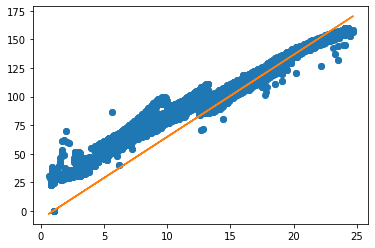

In [28]:
#test_data_mode2
Line= LinearRegression()
temp=test_normal_mode2
x=pd.Series(temp['IMEP average'].values+1)
y=temp['Pmax average']
Line.fit(x.values.reshape(-1,1), y)
print(Line.intercept_,mean_squared_error(y,Line.predict(x.values.reshape(-1,1)))**0.5)
plt.plot(x, y, 'o')
plt.plot(x,Line.predict(x.values.reshape(-1,1)))
plt.show()

#test_normal_mode2
temp=test_normal_mode2
test_normal_mode2['(Pmax average-b)/(IMEP+1)']=(temp['Pmax average'].values-Line.intercept_)/(temp['IMEP average'].values+1)


#test_abnormal_mode2
temp=test_abnormal_mode2
test_abnormal_mode2['(Pmax average-b)/(IMEP+1)']=(temp['Pmax average'].values-Line.intercept_)/(temp['IMEP average'].values+1)

-16.275556858838513 2.3117753652768545


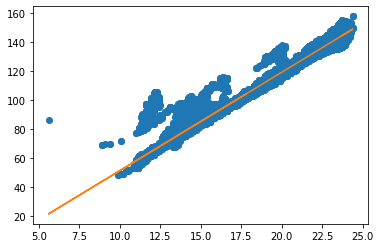

In [29]:
#test_data_mode3
Line= LinearRegression()
temp=test_normal_mode3
x=pd.Series(temp['IMEP average'].values+1)
y=temp['Pmax average']
Line.fit(x.values.reshape(-1,1), y)
print(Line.intercept_,mean_squared_error(y,Line.predict(x.values.reshape(-1,1)))**0.5)
plt.plot(x, y, 'o')
plt.plot(x,Line.predict(x.values.reshape(-1,1)))
plt.show()


#test_normal_mode3
temp=test_normal_mode3
test_normal_mode3['(Pmax average-b)/(IMEP+1)']=(temp['Pmax average'].values-Line.intercept_)/(temp['IMEP average'].values+1)


#test_abnormal_mode3
temp=test_abnormal_mode3
test_abnormal_mode3['(Pmax average-b)/(IMEP+1)']=(temp['Pmax average'].values-Line.intercept_)/(temp['IMEP average'].values+1)

train

-26.071904935768828 0.8194088208454341


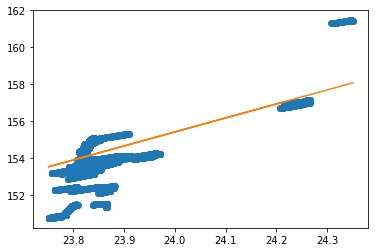

In [30]:
#train_data_mode2
Line= LinearRegression()
temp=train_normal_mode2
x=pd.Series(temp['IMEP average'].values+1)
y=temp['Pmax average']
Line.fit(x.values.reshape(-1,1), y)
print(Line.intercept_,mean_squared_error(y,Line.predict(x.values.reshape(-1,1)))**0.5)
plt.plot(x, y, 'o')
plt.plot(x,Line.predict(x.values.reshape(-1,1)))
plt.show()


#train_normal_mode2
temp=train_normal_mode2
train_normal_mode2['(Pmax average-b)/(IMEP+1)']=(temp['Pmax average'].values-Line.intercept_)/(temp['IMEP average'].values+1)


#train_abnormal_mode2
temp=train_abnormal_mode2
train_abnormal_mode2['(Pmax average-b)/(IMEP+1)']=(temp['Pmax average'].values-Line.intercept_)/(temp['IMEP average'].values+1)

-18.786972052957566 1.7902234679331561


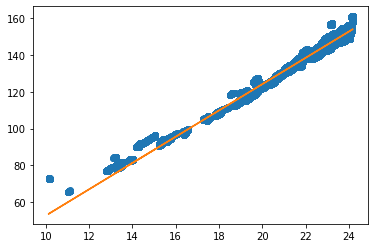

In [31]:
#train_data_mode3
Line= LinearRegression()
temp=train_normal_mode3
x=pd.Series(temp['IMEP average'].values+1)
y=temp['Pmax average']
Line.fit(x.values.reshape(-1,1), y)
print(Line.intercept_,mean_squared_error(y,Line.predict(x.values.reshape(-1,1)))**0.5)
plt.plot(x, y, 'o')
plt.plot(x,Line.predict(x.values.reshape(-1,1)))
plt.show()


#train_normal_mode3
temp=train_normal_mode3
train_normal_mode3['(Pmax average-b)/(IMEP+1)']=(temp['Pmax average'].values-Line.intercept_)/(temp['IMEP average'].values+1)


#train_abnormal_mode3
temp=train_abnormal_mode3
train_abnormal_mode3['(Pmax average-b)/(IMEP+1)']=(temp['Pmax average'].values-Line.intercept_)/(temp['IMEP average'].values+1)

3. Load/(IMEP+1 x Engine speed+1)

In [32]:
col='Load/(IMEP+1 x Engine speed+1)'

In [33]:
temp=test_normal_mode2
temp[col]=(temp['Engine Load percent'].values)/((temp['IMEP average'].values+1)*(temp['Engine Speed 1 (SE11)'].values+1))
test_normal_mode2=temp

temp=test_normal_mode3
temp[col]=(temp['Engine Load percent'].values)/((temp['IMEP average'].values+1)*(temp['Engine Speed 1 (SE11)'].values+1))
test_normal_mode3=temp


temp=test_abnormal_mode2
temp[col]=(temp['Engine Load percent'].values)/((temp['IMEP average'].values+1)*(temp['Engine Speed 1 (SE11)'].values+1))
test_abnormal_mode2=temp

temp=test_abnormal_mode3
temp[col]=(temp['Engine Load percent'].values)/((temp['IMEP average'].values+1)*(temp['Engine Speed 1 (SE11)'].values+1))
test_abnormal_mode3=temp

In [34]:
temp=train_normal_mode2
temp[col]=(temp['Engine Load percent'].values)/((temp['IMEP average'].values+1)*(temp['Engine Speed 1 (SE11)'].values+1))
train_normal_mode2=temp


temp=train_normal_mode3
temp[col]=(temp['Engine Load percent'].values)/((temp['IMEP average'].values+1)*(temp['Engine Speed 1 (SE11)'].values+1))
train_normal_mode3=temp


temp=train_abnormal_mode2
temp[col]=(temp['Engine Load percent'].values)/((temp['IMEP average'].values+1)*(temp['Engine Speed 1 (SE11)'].values+1))
train_abnormal_mode2=temp


temp=train_abnormal_mode3
temp[col]=(temp['Engine Load percent'].values)/((temp['IMEP average'].values+1)*(temp['Engine Speed 1 (SE11)'].values+1))
train_abnormal_mode3=temp

## 7. 다시 정렬하기

In [35]:
#Columns로 정렬
test_normal_mode2=test_normal_mode2[Columns].sort_values('dateTime',ascending=True)
test_normal_mode3=test_normal_mode3[Columns].sort_values('dateTime',ascending=True)
test_abnormal_mode2=test_abnormal_mode2[Columns].sort_values('dateTime',ascending=True)
test_abnormal_mode3=test_abnormal_mode3[Columns].sort_values('dateTime',ascending=True)
train_normal_mode2=train_normal_mode2[Columns].sort_values('dateTime',ascending=True)
train_normal_mode3=train_normal_mode3[Columns].sort_values('dateTime',ascending=True)
train_abnormal_mode2=train_abnormal_mode2[Columns].sort_values('dateTime',ascending=True)
train_abnormal_mode3=train_abnormal_mode3[Columns].sort_values('dateTime',ascending=True)
print(test_normal_mode2.shape, test_abnormal_mode2.shape,train_normal_mode2.shape,train_abnormal_mode2.shape)
print(test_normal_mode3.shape, test_abnormal_mode3.shape,train_normal_mode3.shape,train_abnormal_mode3.shape)

(1503235, 30) (1130668, 30) (23554, 30) (54908, 30)
(1065094, 30) (622556, 30) (1416248, 30) (2750323, 30)


## 8. 정규화하기

In [36]:
Test_mode2=pd.concat([test_normal_mode2,test_abnormal_mode2]).sort_values('dateTime',ascending=True)
Test_mode3=pd.concat([test_normal_mode3,test_abnormal_mode3]).sort_values('dateTime',ascending=True)

Train_mode2=pd.concat([train_normal_mode2,train_abnormal_mode2]).sort_values('dateTime',ascending=True)
Train_mode3=pd.concat([train_normal_mode3,train_abnormal_mode3]).sort_values('dateTime',ascending=True)
print(test_mode2.shape,Test_mode2.shape)
print(test_mode3.shape,Test_mode3.shape)
print(train_mode2.shape,Train_mode2.shape)
print(train_mode3.shape,Train_mode3.shape)
test_mode2=Test_mode2
test_mode3=Test_mode3
train_mode2=Train_mode2
train_mode3=Train_mode3

(2633903, 27) (2633903, 30)
(1687650, 27) (1687650, 30)
(78462, 27) (78462, 30)
(4166571, 27) (4166571, 30)


In [37]:
Scale_col=Columns[:-3]
test_mode2[Scale_col]= RobustScaler().fit_transform(test_mode2[Scale_col])
test_mode3[Scale_col]= RobustScaler().fit_transform(test_mode3[Scale_col])

train_mode2[Scale_col]= RobustScaler().fit_transform(train_mode2[Scale_col])
train_mode3[Scale_col]= RobustScaler().fit_transform(train_mode3[Scale_col])

In [38]:
test_normal_mode2=test_mode2[test_mode2['state']=='normal'].sort_values('dateTime',ascending=True)
test_abnormal_mode2=test_mode2[test_mode2['state']=='abnormal'].sort_values('dateTime',ascending=True)
test_normal_mode3=test_mode3[test_mode3['state']=='normal'].sort_values('dateTime',ascending=True)
test_abnormal_mode3=test_mode3[test_mode3['state']=='abnormal'].sort_values('dateTime',ascending=True)

train_normal_mode2=train_mode2[train_mode2['state']=='normal'].sort_values('dateTime',ascending=True)
train_abnormal_mode2=train_mode2[train_mode2['state']=='abnormal'].sort_values('dateTime',ascending=True)
train_normal_mode3=train_mode3[train_mode3['state']=='normal'].sort_values('dateTime',ascending=True)
train_abnormal_mode3=train_mode3[train_mode3['state']=='abnormal'].sort_values('dateTime',ascending=True)

print(np.all(test_normal_mode2['state']=='normal'))
print(np.all(test_normal_mode3['state']=='normal'))
print(np.all(test_abnormal_mode2['state']=='abnormal'))
print(np.all(test_abnormal_mode3['state']=='abnormal'))
print(np.all(train_normal_mode2['state']=='normal'))
print(np.all(train_normal_mode3['state']=='normal'))
print(np.all(train_abnormal_mode2['state']=='abnormal'))
print(np.all(train_abnormal_mode3['state']=='abnormal'))

True
True
True
True
True
True
True
True


## 9. 다시 시간에 대해서 자르기

In [39]:
Spliting=pd.DataFrame(index=['mode2','mode3'],columns=['test_normal','test_abnormal','train_normal','train_abnormal'])
OneSecond=test_data.iloc[1,25]-test_data.iloc[0,25]

In [40]:
#test_normal_mode2
temp=test_normal_mode2
where_something=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
for i in range(len(where_something)+1):
    if i==0:
        test_normal_mode2_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="test_normal_mode2_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="test_normal_mode2_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
Spliting.iloc[0,0]=len(where_something)+1 
where_something=0

In [41]:
#test_normal_mode3
temp=test_normal_mode3
where_something=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
for i in range(len(where_something)+1):
    if i==0:
        test_normal_mode3_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="test_normal_mode3_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="test_normal_mode3_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
Spliting.iloc[1,0]=len(where_something)+1 
where_somthing=0

In [42]:
#test_abnormal_mode2
temp=test_abnormal_mode2
where_something=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
for i in range(len(where_something)+1):
    if i==0:
        test_abnormal_mode2_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="test_abnormal_mode2_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="test_abnormal_mode2_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
Spliting.iloc[0,1]=len(where_something)+1 
where_something=0

In [43]:
#test_abnormal_mode3
temp=test_abnormal_mode3
where_something=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
for i in range(len(where_something)+1):
    if i==0:
        test_abnormal_mode3_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="test_abnormal_mode3_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="test_abnormal_mode3_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
Spliting.iloc[1,1]=len(where_something)+1 
where_something=0

train

In [44]:
#train_normal_mode2
temp=train_normal_mode2
where_something=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
for i in range(len(where_something)+1):
    if i==0:
        train_normal_mode2_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="train_normal_mode2_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="train_normal_mode2_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
Spliting.iloc[0,2]=len(where_something)+1 
where_something=0

In [45]:
#train_normal_mode3
temp=train_normal_mode3
where_something=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
for i in range(len(where_something)+1):
    if i==0:
        train_normal_mode3_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="train_normal_mode3_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="train_normal_mode3_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
Spliting.iloc[1,2]=len(where_something)+1 
where_something=0

In [46]:
#train_abnormal_mode2
temp=train_abnormal_mode2
where_something=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
for i in range(len(where_something)+1):
    if i==0:
        train_abnormal_mode2_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="train_abnormal_mode2_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="train_abnormal_mode2_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
Spliting.iloc[0,3]=len(where_something)+1 
where_something=0

In [47]:
#train_abnormal_mode3
temp=train_abnormal_mode3
where_something=np.array(np.where((temp['dateTime'].iloc[1:].values-temp['dateTime'].iloc[:-1].values)!=OneSecond))[0]
for i in range(len(where_something)+1):
    if i==0:
        train_abnormal_mode3_1=temp.iloc[:where_something[0]+1,:]
    elif i==len(where_something):
        s2="train_abnormal_mode3_%d=temp.iloc[where_something[%d]+1:,:]" %(i+1,i-1)
        exec(s2)
    else:
        s3="train_abnormal_mode3_%d=temp.iloc[where_something[%d]+1:where_something[%d]+1,:]" %(i+1,i-1,i)
        exec(s3)
Spliting.iloc[1,3]=len(where_something)+1 
where_something=0

In [48]:
Spliting

,test_normal,test_abnormal,train_normal,train_abnormal
mode2,38,29,19,22
mode3,40,28,166,683


## 10. 데이터 저장하기

In [51]:
#NumofData
Spliting.to_csv('./Final 전처리된data/AmountOfDataAll',sep=',')

#test_normal_mode2
temp='test_normal_mode2'
for i in range(int(Spliting['test_normal'].iloc[0])):
    s1="%s_%d.to_csv('./Final 전처리된data/%s_%d',sep=',',index=None)" %(temp,i+1,temp,i+1) 
    exec(s1)
print(i+1)    
    
#test_normal_mode3
temp='test_normal_mode3'
for i in range(int(Spliting['test_normal'].iloc[1])):
    s1="%s_%d.to_csv('./Final 전처리된data/%s_%d',sep=',',index=None)" %(temp,i+1,temp,i+1)
    exec(s1)
print(i+1)
    
#test_abnormal_mode2
temp='test_abnormal_mode2'
for i in range(int(Spliting['test_abnormal'].iloc[0])):
    s1="%s_%d.to_csv('./Final 전처리된data/%s_%d',sep=',',index=None)" %(temp,i+1,temp,i+1)
    exec(s1)
print(i+1)    
    
#test_abnormal_mode3
temp='test_abnormal_mode3'
for i in range(int(Spliting['test_abnormal'].iloc[1])):
    s1="%s_%d.to_csv('./Final 전처리된data/%s_%d',sep=',',index=None)" %(temp,i+1,temp,i+1)
    exec(s1)
print(i+1)    
    
    
    
#train_normal_mode2
temp='train_normal_mode2'
for i in range(int(Spliting['train_normal'].iloc[0])):
    s1="%s_%d.to_csv('./Final 전처리된data/%s_%d',sep=',',index=None)" %(temp,i+1,temp,i+1) 
    exec(s1)
print(i+1)    
    
#test_normal_mode3
temp='train_normal_mode3'
for i in range(int(Spliting['train_normal'].iloc[1])):
    s1="%s_%d.to_csv('./Final 전처리된data/%s_%d',sep=',',index=None)" %(temp,i+1,temp,i+1)
    exec(s1)

print(i+1)    
    
    
#test_abnormal_mode2
temp='train_abnormal_mode2'
for i in range(int(Spliting['train_abnormal'].iloc[0])):
    s1="%s_%d.to_csv('./Final 전처리된data/%s_%d',sep=',',index=None)" %(temp,i+1,temp,i+1)
    exec(s1)
print(i+1)

    
#test_abnormal_mode3
temp='train_abnormal_mode3'
for i in range(int(Spliting['train_abnormal'].iloc[1])):
    s1="%s_%d.to_csv('./Final 전처리된data/%s_%d',sep=',',index=None)" %(temp,i+1,temp,i+1)
    exec(s1)
print(i+1)

38
40
29
28
19
166
22
683
